In [43]:
import numpy as np
import pandas as pd
from scipy.special import erf
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import lognorm
from pytictoc import TicToc
from scipy.stats import ncx2

/Users/diogogeraldes/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


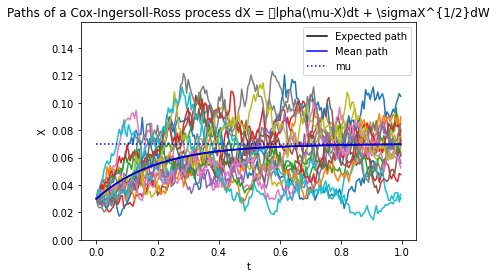

In [44]:
#Simulate a Cox-Ingersoll-Ross process
#dX = alpha*(mu-X)*dt + sigma*sqrt(X)*dW

#Define parameters and time grid
npaths=np.power(10,4)*2 #number of paths
T=1 #time horizon
nsteps=200 #number of time steps
dt=T/nsteps #time step
t=np.arange(0,T,dt) #observation times
mu,sigma,alpha=0.07,0.265,5 #model parameters
X0=0.03 #initial value
timing=TicToc()

#Allocate and initialise all paths
X=[np.zeros(nsteps)]*npaths
X=np.insert(X,0,X0,axis=1)
X=np.delete(X,-1,axis=1)

#Sample standard Gaussian random numbers
N=np.random.randn(npaths,nsteps)

#Degrees of freedom of the non-central chi square distribution
#d= 4*alpha*mu/sigma**2
lambdas=np.zeros(nsteps*npaths).reshape(npaths,nsteps)
#Compute and accumulate the increments
a = sigma**2/alpha*(np.exp(-alpha*dt)-np.exp(-2*alpha*dt)) #Euler with analytic moments
b = mu*sigma**2/(2*alpha)*(1-np.exp(-alpha*dt))**2 #Euler with analytic moments
#k= sigma**2*(1-np.exp(-alpha*dt))/(4*alpha) #exact method
for i in range(nsteps-1):
    for j in range(npaths):
        #X[j][i+1]=X[j][i] + alpha*(mu-X[j][i])*dt + sigma*np.sqrt(X[j][i]*dt)*N[j][i] #plain Euler
        X[j][i+1]=mu+(X[j][i]-mu)*np.exp(-alpha*dt) + np.sqrt(a*X[j][i]+b)*N[j][i] #Euler with analytic moments
        #lambdas[j][i+1]=4*alpha*X[j][i]/(sigma**2*(np.exp(alpha*dt)-1))

#Compute the expected path
EX=mu+(X0-mu)*np.exp(-alpha*t)

#Plot the expected, mean and sample paths
plt.figure(1)
df=pd.concat([pd.Series(x) for x in X], axis=1)
mean_df=df.apply(lambda row: np.mean(row),axis=1) #mean per step
for k in range(int(nsteps/10)):
    plt.plot(t,X[k])
plt.plot(t,EX,'k',label='Expected path')
plt.plot(t,mean_df,'b',label='Mean path')
plt.plot(t,np.ones(nsteps)*mu,':b',label='mu')
sdevinfty = sigma*np.sqrt(mu/(2*alpha))
plt.legend()
plt.xlabel('t')
plt.ylabel('X')
plt.ylim([0,mu+4*sdevinfty])
plt.title('Paths of a Cox-Ingersoll-Ross process dX = \alpha(\mu-X)dt + \sigmaX^{1/2}dW')
plt.show()

/Users/diogogeraldes/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


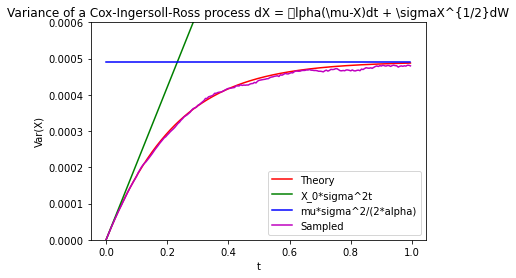

In [45]:
#Plot the variance
plt.figure(2)
#See e.g. PDE Tools page 64
var_df=df.apply(lambda row: np.var(row),axis=1) #var per step
variance =X0*sigma**2/alpha*(np.exp(-alpha*t)-np.exp(-2*alpha*t)) + mu*sigma**2/(2*alpha)*(1-np.exp(-alpha*t))**2
var0 = X0*sigma**2*t
varinfty = mu*sigma**2/(2*alpha)*np.ones(np.size(t))
plt.plot(t,variance,'r',t,var0,'g',t,varinfty,'b',t,var_df,'m')
plt.legend(['Theory','X_0*sigma^2t','mu*sigma^2/(2*alpha)','Sampled'])
plt.xlabel('t')
plt.ylabel('Var(X)')
plt.ylim([0,0.0006])
plt.title('Variance of a Cox-Ingersoll-Ross process dX = \alpha(\mu-X)dt + \sigmaX^{1/2}dW')
plt.show()

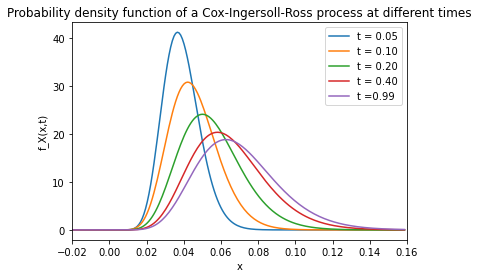

In [65]:
#Compute and plot the probability density function at different times
t2 = [0.05,0.1,0.2,0.4,0.99]
x2 = np.linspace(-0.02,mu+4*sdevinfty,200)
k2=np.zeros(len(t2))
for l in range(len(t2)):
    k2[l]=sigma**2*(1-np.exp(-alpha*t2[l]))/(4*alpha)
d = 4*alpha*mu/sigma**2
lambdaz=np.zeros(len(t2)) #non-centrality parameter
for o in range(len(t2)):
    lambdaz[o] = 4*alpha*X0/(sigma**2*(np.exp(alpha*t2[o])-1))
f=[np.zeros(len(x2))]*len(t2)
for p in range(len(t2)):
    f[p]=ncx2.pdf(x2/k2[p],d,lambdaz[p])/k2[p]
plt.figure(3)
for y in range(len(f)):
    plt.plot(x2,f[y])
plt.title('Probability density function of a Cox-Ingersoll-Ross process at different times')
plt.xlabel('x')
plt.ylabel('f_X(x,t)')
plt.xlim([-0.02,0.16])
plt.legend(['t = 0.05','t = 0.10','t = 0.20','t = 0.40','t =0.99'])
plt.show()